In [8]:

! git clone https://github.com/sanjay-kv/CURL


Cloning into 'CURL'...
remote: Enumerating objects: 561, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 561 (delta 136), reused 142 (delta 131), pack-reused 405
Receiving objects: 100% (561/561), 99.60 MiB | 29.98 MiB/s, done.
Resolving deltas: 100% (316/316), done.


In [9]:
cd ./CURL/

/content/CURL/CURL


In [10]:
! ls

 adobe5k_dpe		   images	       README.md
'Colab Demo.ipynb'	   main.py	       requirements.txt
 CURL_for_RGB_images.zip   metric.py	       rgb_ted.py
 CURL_large_batch.tar.gz   model.py	       util.py
 CURL_refactored.tar.gz    pretrained_models
 data.py		   raw_ted.py


In [11]:
import numpy as np
from PIL import Image
import sys
import torch
import torchvision.transforms.functional as TF
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Imports from the code written by authors inside modules
import model
import util
from util import ImageProcessing

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #

In [12]:
def resize(image, new_width_height = 1920, convert_RGB = True):
  '''
  Resize and return Given Image
  args:
    path: Image Path, BytesIO or the image 
    new_width_height = Reshaped image's width and height. # If integer is given, it'll keep the aspect ratio as it is by shrinking the Bigger dimension (width or height) to the max of new_width_height  and then shring the smaller dimension accordingly 
    convert_RGB: Whether to Convert the RGBA image to RGB (by default backgroud is white)
  '''
  image = Image.open(image) if isinstance(image, (str, BytesIO)) else image
  w, h = image.size

  fixed_size = new_width_height if isinstance(new_width_height, int) else False

  if fixed_size:
    if h > w:
      fixed_height = fixed_size
      height_percent = (fixed_height / float(h))
      width_size = int((float(w) * float(height_percent)))
      image = image.resize((width_size, fixed_height), Image.NEAREST)

    else:
      fixed_width = fixed_size
      width_percent = (fixed_width / float(w))
      height_size = int((float(h) * float(width_percent)))
      image = image.resize((fixed_width, height_size), Image.NEAREST) # Try Image.ANTIALIAS inplace of Image.NEAREST

  else:
    image = image.resize(new_width_height)

  if image.mode == "RGBA" and convert_RGB:
  
    new = Image.new("RGBA", image.size, "WHITE") # Create a white rgba background
    new.paste(image, (0, 0), image) # Paste the image on the background.
    image = new.convert('RGB')

  return image



def load_image(path, resize_image_size = 1920):
    '''
    Load the image as tensor according to the format authors have used in the code
    '''
    if ("https" in path) or ("http" in path):
      image = Image.open(BytesIO(requests.get(path).content))

    else:
      image = Image.open(path)

    if image.mode != 'RGB':
      image = image.convert('RGB')
    
    if resize:
      image = resize(image, resize_image_size)
               
    return TF.to_tensor(image).to(DEVICE)
     

In [13]:
checkpoint_filepath = "./pretrained_models/adobe_dpe/curl_validpsnr_23.073045286204017_validloss_0.0701291635632515_testpsnr_23.584083321292365_testloss_0.061363041400909424_epoch_510_model.pt"

# Build Model
net = model.CURLNet()
checkpoint = torch.load(checkpoint_filepath, map_location=DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()
if DEVICE == 'cuda':
  net.cuda()


def evaluate(img, convert_uint = False):
    """
    Evaluate the model per image instance. Image of Batch size 1. Can be used in API production
    """
    img = load_image(img)

    with torch.no_grad():

        img = img.unsqueeze(0)
        img = torch.clamp(img, 0, 1)

        net_output_img_example , _ = net(img)

        net_output_img_example_numpy = net_output_img_example.squeeze(0).data.cpu().numpy()
        net_output_img_example_numpy = ImageProcessing.swapimdims_3HW_HW3(net_output_img_example_numpy)
        return (net_output_img_example_numpy* 255).astype(np.uint8) if convert_uint else net_output_img_example_numpy
     
     

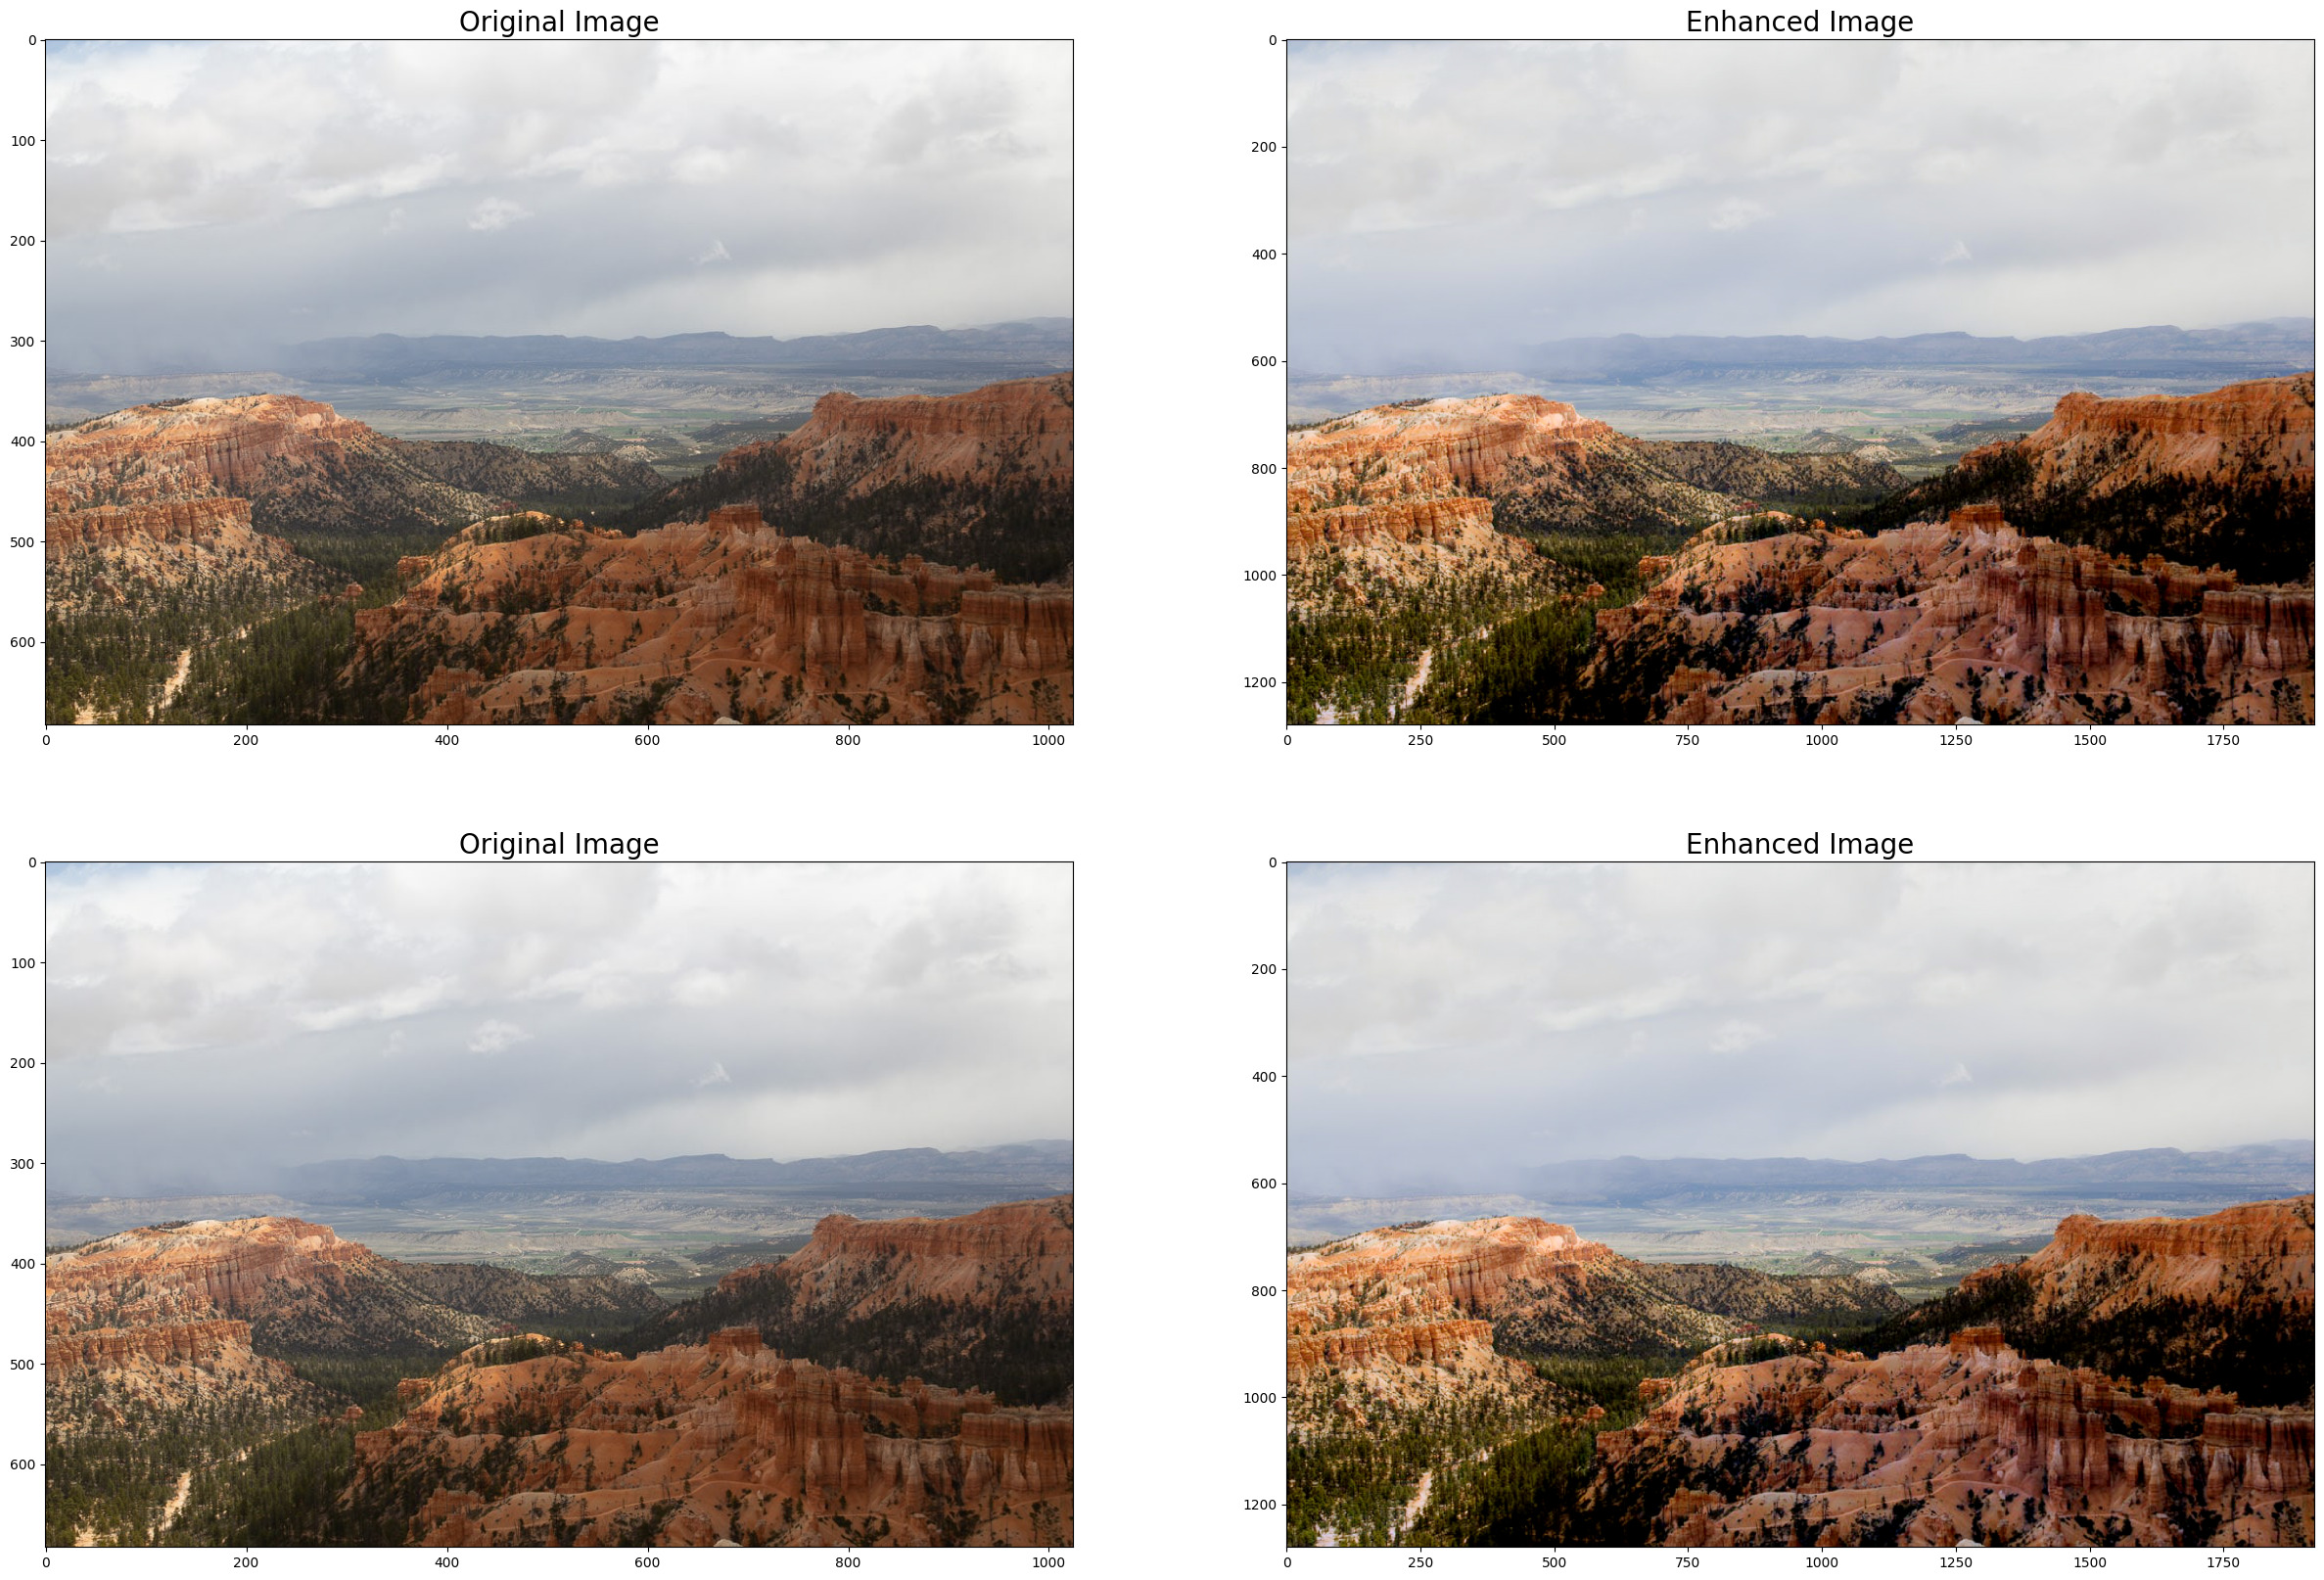

In [14]:

urls = ["https://phototraces.b-cdn.net/wp-content/uploads/2021/03/Free_RAW_Photos_for_Editing_13_Unedited.jpg",
      "https://phototraces.b-cdn.net/wp-content/uploads/2021/03/Free_RAW_Photos_for_Editing_13_Unedited.jpg"
      ]

%matplotlib inline
f, ax = plt.subplots(2,2, figsize = (30,20))

for i, url in enumerate(urls):

  result = evaluate(url, convert_uint = False) # gives you array between 0-1 so if you want an "Image", use 'convert_uint = True', then Image.fromarray(array).save(path)

  ax[i][0].imshow(np.array(Image.open(BytesIO(requests.get(url).content)))) # Original image
  ax[i][1].imshow(result) # retouched

  ax[i][0].set_title("Original Image", fontsize=20)
  ax[i][1].set_title("Enhanced Image", fontsize=20)

plt.show()